In [1]:
# load the data 
filepath = "run_all_forest_20.txt"
text = ''
with open(filepath, "r") as f:
    text = f.read()
# we get the random states
chunks = text.split("\nStates")
error_groups = [] 

def parse_first_line(line):
    info = line.split(",")
    info = [x.split(": ") for x in info]
    return info[0][-1], info[1][-1], info[2][-1], info[3][-1]
    
def parse_order(chunk, test):
    if len(chunk) < 4:
        print(chunk)
        print(test)
    total_acc = float(chunk[2].split(": ")[-1])
    control_acc = float(chunk[3].split(": ")[-1])
    pd_acc = float(chunk[4].split(": ")[-1])
    return total_acc, control_acc, pd_acc

def parse_chunk(chunk, print_error=True):
    lines = chunk.split("\n")
    lines = [x for x in lines if x != ""]
    
    n_maps, random_state, sampling, test_size = parse_first_line(lines[0])
    
    if "Error" in lines[-1]:
        if "AssertionError" in lines[-1]:
            error_groups.append(f"{random_state}_{sampling}_{test_size}")
        return n_maps, f"{random_state}_{sampling}_{test_size}", {"first_order":"ERROR", 
                                                                  "second_order":"ERROR",
                                                                  "zero_order":"ERROR"}
        
    index = 0
    for line in lines:
        if "First Order" not in line:
            index += 1 
        else:
            break
    first_order = lines[index:index+5]
    second_order = lines[index+6+10:index+6+10+5]
    
    for line in lines[index:]:
        if "Zero Order" not in line:
            index += 1 
        else:
            break
    zero_order = lines[index:index+5]
    (first_total_acc, first_control_acc, first_pd_acc) = parse_order(first_order, chunk)
    (second_total_acc, second_control_acc, second_pd_acc) = parse_order(second_order, chunk)
    (zero_total_acc, zero_control_acc, zero_pd_acc) = parse_order(zero_order, chunk)
    
    results = {"first_order": [first_total_acc, first_control_acc, first_pd_acc],
               "second_order": [second_total_acc, second_control_acc, second_pd_acc],
               "zero_order": [zero_total_acc, zero_control_acc, zero_pd_acc]}
    
    return (n_maps, f"{random_state}_{sampling}_{test_size}", results)
    
    

# put it into by number of classes
class_to_results = {}
for chunk in chunks:
    if chunk != "":
        #assert len(parse_chunk(chunk))==3, chunk
        n_maps, value, result = parse_chunk(chunk)
        if n_maps not in class_to_results:
            class_to_results[n_maps] = {"values":[value], "results":[result]}
        else:
            class_to_results[n_maps]["values"].append(value)
            class_to_results[n_maps]["results"].append(result)
print(len(class_to_results))

1


In [2]:
# we parse the other output file 
# load the data 
"""
filepath_down = "random_forest/results_4.txt"
text_down = ''
with open(filepath_down, "r") as f:
    text_down = f.read()
# we get the random states
chunks = text_down.split("\nStates")
for chunk in chunks:
    if chunk != "":
        n_maps, value, result = parse_chunk(chunk)
        if n_maps not in class_to_results:
            class_to_results[n_maps] = {"values":[value], "results":[result]}
        else:
            class_to_results[n_maps]["values"].append(value)
            class_to_results[n_maps]["results"].append(result)
#print(len(values))
print(error_groups)
"""

'\nfilepath_down = "random_forest/results_4.txt"\ntext_down = \'\'\nwith open(filepath_down, "r") as f:\n    text_down = f.read()\n# we get the random states\nchunks = text_down.split("\nStates")\nfor chunk in chunks:\n    if chunk != "":\n        n_maps, value, result = parse_chunk(chunk)\n        if n_maps not in class_to_results:\n            class_to_results[n_maps] = {"values":[value], "results":[result]}\n        else:\n            class_to_results[n_maps]["values"].append(value)\n            class_to_results[n_maps]["results"].append(result)\n#print(len(values))\nprint(error_groups)\n'

In [3]:
# figure out the groups most common errors 
print(error_groups)
print(f"{len(error_groups)}/{4*1000*3}")
error_sampling = {}
error_test_sizes = {}
for error in error_groups:
    info = error.split("_")
    if info[1] not in error_sampling:
        error_sampling[info[1]] = 1
    else:
        error_sampling[info[1]] += 1
    if info[2] not in error_test_sizes:
        error_test_sizes[info[2]] = 1
    else:
        error_test_sizes[info[2]] += 1
print(error_sampling)
print(error_test_sizes)
print({k:round(v/(4*1000*3),4) for k,v in error_sampling.items()})
print({k:round(v/(4*1000*3),4) for k,v in error_test_sizes.items()})

[]
0/12000
{}
{}
{}
{}


In [4]:
# so now we do plotting of the results so we should plot the accuarcy and find the average for the different versions
values = class_to_results["4"]["values"]
results = class_to_results["4"]["results"]

def get_average(values, results, order, test_size=0):
    sampling_to_acc_total = {"up":[], "down":[], "syn":[]}
    sampling_to_acc_control = {"up":[], "down":[], "syn":[]}
    sampling_to_acc_patient = {"up":[], "down":[], "syn":[]}

    for index,val in enumerate(values):
        if test_size != float(val.split("_")[2]) and test_size !=0:
            continue

        if results[index]["first_order"] != "ERROR":
            sampling_to_acc_total[val.split("_")[1]].append(results[index][order][0])
            sampling_to_acc_control[val.split("_")[1]].append(results[index][order][1])
            sampling_to_acc_patient[val.split("_")[1]].append(results[index][order][2])

    return sampling_to_acc_total, sampling_to_acc_control, sampling_to_acc_patient

first_acc_total,first_acc_control,first_acc_patient = get_average(values, results, "first_order")
second_acc_total,second_acc_control,second_acc_patient = get_average(values, results, "second_order")
zero_acc_total,zero_acc_control,zero_acc_patient = get_average(values, results, "zero_order")

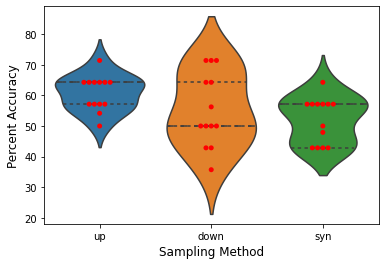

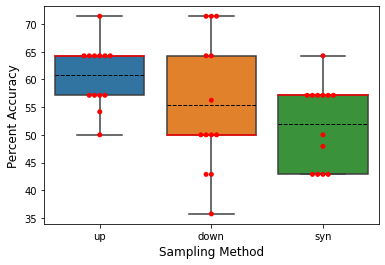

In [39]:
# violin plot to get the distributions 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def dict_to_df(accs):
    Y = []
    X = []
    for key in accs:
        X.extend([key]*len(accs[key]))
        Y.extend(accs[key])

    return pd.DataFrame({"x":X, "y":Y})

def violin_plot(df, x_name, y_name, title):
    # Draw Plot
    ax = sns.violinplot(x=x_name, y=y_name, data=df, scale='width', inner='quartile')
    ax = sns.swarmplot(x=x_name, y=y_name, data=df, color="red")
    # Decoration
    plt.xlabel("Sampling Method", fontsize=12)
    plt.ylabel("Percent Accuracy", fontsize=12)
    plt.savefig(title)
    plt.show()

def box_plot(df, x_name, y_name, title):
     
    # Usual boxplot
    ax = sns.boxplot(x=x_name, y=y_name, data=df, medianprops={'color':'red'}, meanline=True, showmeans=True, 
                     meanprops={'color':'black'})

    # Add jitter with the swarmplot function.
    ax = sns.swarmplot(x=x_name, y=y_name, data=df, color="red")
    plt.xlabel("Sampling Method", fontsize=12)
    plt.ylabel("Percent Accuracy", fontsize=12)
    plt.savefig(title)
    plt.show()
df = dict_to_df(first_acc_total)
violin_plot(df, "x", "y", "violin_plot")
box_plot(df, "x", "y", "box_plot")

In [7]:
df = dict_to_df(second_acc_total)
violin_plot(df, "x", "y")
box_plot(df, "x", "y")

TypeError: violin_plot() missing 1 required positional argument: 'title'

In [ ]:
import matplotlib.pyplot as plt

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

def create_bar_graph(sampling_to_acc_total,sampling_to_acc_control,sampling_to_acc_patient, title):
    fig = plt.figure(figsize=(14,6))
    #ax = fig.add_axes([0,0,1,1])
    ax = fig.add_axes([0.1,0.1,0.75,0.75]) # axis starts at 0.1, 0.1
    colors = ["c", "m", "y"]
    sampling = ["up", "down", "syn"]
    all_rects = []
    for i,key in enumerate(sampling):
        average_total = sum(sampling_to_acc_total[key])/len(sampling_to_acc_total[key])
        average_control = sum(sampling_to_acc_control[key])/len(sampling_to_acc_total[key])
        average_patient = sum(sampling_to_acc_patient[key])/len(sampling_to_acc_patient[key])
        names = [f"{key}_Total", f"{key}_Control", f"{key}_PD"]
        averages = [average_total,average_control,average_patient ]
        rects = ax.bar(names,averages,color=colors[i])
        autolabel(rects, ax)
        all_rects.append(rects)
    ax.legend((all_rects[0][0], all_rects[1][0],all_rects[2][0]), sampling)
    ax.set_xticklabels(["Total", "Control", "PD"]*3)
    plt.xticks(fontsize=14)
    fig.savefig(title)
    plt.show()

# second_acc_total,second_acc_control,second_acc_patient = get_average(values, results, "first_order", 0.20)
# create_bar_graph(second_acc_total,second_acc_control,second_acc_patient, "nothing")

In [ ]:
# do it for all classes 
values = class_to_results["4"]["values"]
results = class_to_results["4"]["results"]
first_acc_total,first_acc_control,first_acc_patient = get_average(values, results, "first_order")
second_acc_total,second_acc_control,second_acc_patient = get_average(values, results, "second_order")
zero_acc_total,zero_acc_control,zero_acc_patient = get_average(values, results, "zero_order")

create_bar_graph(zero_acc_total,zero_acc_control,zero_acc_patient, "zero_order")
create_bar_graph(first_acc_total,first_acc_control,first_acc_patient, "first_order")
create_bar_graph(second_acc_total,second_acc_control,second_acc_patient, "second_order")